In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
import seaborn as sns

import math
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

### Importing and cleaning 2013 NY Crime Data

In [3]:
df1 = pd.read_csv("NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013 - 13tbl8ny.csv", skiprows=3, header=1)

In [4]:
ny_data = df1.copy()

In [5]:
features = ny_data[['Population', 'Murder and\nnonnegligent\nmanslaughter', 'Robbery', 'Property\ncrime']]

In [6]:
features = features.rename(columns={'Murder and\nnonnegligent\nmanslaughter' : 'Murder', 'Property\ncrime' : 'Property_crime'})

In [7]:
features = features.dropna()

In [8]:
def remove_commas(number):
    if ',' in number:
        return number.replace(',', '')
    else:
        return number
    
def crime_categorical(number):
    if number > 0:
        return 1 
    else:
        return 0

In [9]:
features['Population'] = features.Population.apply(lambda x: remove_commas(x))
features['Robbery'] = features.Robbery.apply(lambda x: remove_commas(x))
features['Property_crime'] = features['Property_crime'].apply(lambda x: remove_commas(x))

features['Population'] = features.Population.apply(lambda x: float(x))
features['Robbery'] = features.Robbery.apply(lambda x: int(x))
features['Property_crime'] = features['Property_crime'].apply(lambda x: float(x))

features['Robbery'] = features['Robbery'].apply(lambda x: crime_categorical(x))
features['Murder'] = features['Murder'].apply(lambda x: crime_categorical(x))

In [10]:
features['Population_2'] = features['Population']**2

In [11]:
#I checked and found that Population had one huge outlier
sorted(features['Population'], reverse=True)

features = features.drop([216])

### Linearly regressing 2013 NY Crime Data

In [12]:
regr = linear_model.LinearRegression()
Y = features['Property_crime'].values.reshape(-1, 1) #I'm interested in knowing the point of this reshape and values
X = features[['Population', 'Murder', 'Robbery', 'Population_2']]
regr.fit(X, Y)

from sklearn.model_selection import cross_val_score
cross_val_score(regr, X, Y, cv=10)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


array([ 0.76250721,  0.93768962,  0.30362684,  0.82852638,  0.76061806,
        0.79761978,  0.55797031,  0.90258876,  0.84926337, -1.60913897])

In [13]:
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[1.29510791e-02 1.95038659e+02 9.28205977e+01 1.14920523e-07]]

Intercept: 
 [-16.81574038]

R-squared:
0.8444937611172963


### Importing and cleaning 2013 IL Crime Data

In [14]:
il_data = pd.read_excel('ill_crime.xls', header=1, skiprows=3)

In [15]:
features1 = il_data[['Population', 'Murder and\nnonnegligent\nmanslaughter', 'Robbery', 'Property\ncrime']]
features1 = features1.rename(columns={'Murder and\nnonnegligent\nmanslaughter' : 'Murder', 'Property\ncrime' : 'Property_crime'})
features1['Population_2'] = features1['Population']**2
features1 = features1.drop([77])
features1 = features1.dropna()

features1['Robbery'] = features1['Robbery'].apply(lambda x: crime_categorical(x))
features1['Murder'] = features1['Murder'].apply(lambda x: crime_categorical(x))

### Running IL data through the NY model to see how it does.

In [17]:
Y3 = features1['Property_crime'].values.reshape(-1, 1)
X3 = features1[['Population', 'Murder', 'Robbery', 'Population_2']]

cross_val_score(regr, X3, Y3, cv=10)

array([-0.62871748,  0.8519093 ,  0.69939254,  0.57002607,  0.84191766,
        0.68766447,  0.35712053,  0.66510634,  0.68718876,  0.775648  ])

In [39]:
# Answer: it does not do so great.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X3, Y3))


Coefficients: 
 [[1.29510791e-02 1.95038659e+02 9.28205977e+01 1.14920523e-07]]

Intercept: 
 [-16.81574038]

R-squared:
0.6618732608516583


### P-values and R-squared for 2013 NY Crime Data

In [20]:
# The assigned formula for training Statsmodels model.
linear_formula = 'Property_crime ~ Population+Murder+Robbery+Population_2'

In [21]:
# Fitting ny_stats with the data from 2013 ny crime
ny_stats = smf.ols(formula=linear_formula, data=features).fit()

In [22]:
# Printing out how well ny_stats does at predicting the training data.
print('ny_stats.params:\n', ny_stats.params)
print('\n')
print('ny_stats.pvalues:\n', ny_stats.pvalues)
print('\n')
print('ny_stats.rsquared:\n', ny_stats.rsquared)

ny_stats.params:
 Intercept      -16.816
Population       0.013
Murder         195.039
Robbery         92.821
Population_2     0.000
dtype: float64


ny_stats.pvalues:
 Intercept      0.641
Population     0.000
Murder         0.011
Robbery        0.072
Population_2   0.000
dtype: float64


ny_stats.rsquared:
 0.8444937611173492


The cross validation showed a lot of inconsistency in r squared values for the ny_data.

Since Robbery has a pvalue over .05, I would like to re-fit the model without it and see what happens.

### Let's see how close the predictions are to the actual values.

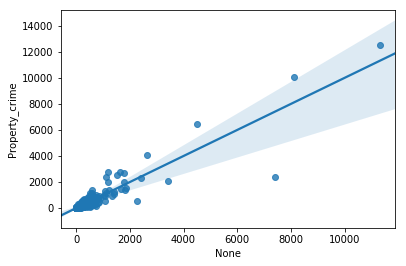

In [37]:
ny_pred = ny_stats.predict(features)

sns.regplot(ny_pred, features.Property_crime)
plt.show()

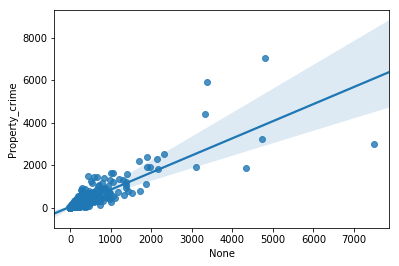

In [38]:
il_pred = ny_stats.predict(features1)

sns.regplot(il_pred, features1.Property_crime)
plt.show()

### Based on what we've seen, it's worth trying without Robbery

In [27]:
linear_formula2 = 'Property_crime ~ Population+Murder+Population_2'

In [28]:
ny_stats_2 = smf.ols(formula=linear_formula2, data=features).fit()

In [29]:
print('ny_stats_2.params : ', ny_stats_2.params)
print('\n')
print('ny_stats_2.pvalues : ', ny_stats_2.pvalues)
print('\n')
print('ny_stats_2.rsquared : ', ny_stats_2.rsquared)

ny_stats_2.params :  Intercept       18.862
Population       0.014
Murder         206.933
Population_2     0.000
dtype: float64


ny_stats_2.pvalues :  Intercept      0.533
Population     0.000
Murder         0.007
Population_2   0.000
dtype: float64


ny_stats_2.rsquared :  0.8430132637316969


In [44]:
# Finding Cross Validation scores
regr2 = linear_model.LinearRegression()
Y = features['Property_crime'].values.reshape(-1, 1)
X2 = features[['Population', 'Murder', 'Population_2']]
regr2.fit(X2, Y)

#cross validation with robbery removed
cross_val_score(regr2, X2, Y, cv=10)

print(regr2.score(X2, Y))

0.8430132637316519


I'm still not sure how to use statsmodels to see how well 

### I like it better without robbery. Everything seems much cleaner.